# Project 3: Data Wrangling Open Street Maps for Orlando, Florida

I have chosen to do my Data Wrangling map on the Open Street Maps of Orlando, Florida and some areas surrounding it. The purpose of the exercise is to learn the difficulties of working with user input. It is also an exercise in working with XML and Sqlite. All the functions I created/borrowed from exercises/improvized are in a file called audit.py.

## Project Plan

I plan to start off parsing the xml in the following cell. I will write some functions to explore the contents of the xml file, so that the contents of the data is clear. Then I will perform some checks on the data to test data quality and make adjustments where possible. Then I will write up the xml files into csv files, and then convert it into a sqlite database.

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import xml.etree.ElementTree as ET  # Use cElementTree or lxml if too slow
import xml.etree.cElementTree as cET
from collections import defaultdict
import numpy as np
import sqlite3
import matplotlib
import audit
from matplotlib import pyplot as plt
import seaborn as sns
import re
import pprint
import cerberus
import jsonschema
import csv
import codecs

#paths to the osm files
OSM_FILE = "open_street_map/orlando.osm"
SAMPLE_FILE = "open_street_map/remake_sample.osm"

#I make the sample file from the original osm file, by  writing down
#one top level element from every k (variable to be adjusted) top level elements
#There are three types of elements from 
#open street map: node, way, relation (osm wiki). 
#Parameter: take every k-th top level element
k = 10 

#Use the get element function to write up a sample file:
with open(SAMPLE_FILE, 'wb') as output:
    output.write(str.encode('<?xml version="1.0" encoding="UTF-8"?>\n'))
    output.write(str.encode('<osm>\n  '))

    # Write every kth top level element
    for i, element in enumerate(audit.get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write(str.encode('</osm>'))

## Ensuring Data Quality

The code above makes a small sample file out of the total data for an area of interest. I imported 633.6 MB of data in my original OSM file centered around Orlando, Florida - which is one of my favorite cities. I made a small sample file of size 16 MB, which I would use for some auditing to find possible issues. I need to ensure that the data I transfer to sqlite conforms to the following standards:

* __It is valid:__ It conforms to a schema
* __It is accurate:__ Check against some accurate source to see that the data is real and correct.
* __It is complete:__ In case of cross matching, we need to make sure the data is complete.
* __It is consistent:__ Cross match fields to see the data set is consistent.
* __Uniformity:__ Correct units!

To start, let's look at the OSM data structure, by printing out some ways, nodes and relations - which is how the OSM data is organized.

In [2]:
audit.print_a_tag(SAMPLE_FILE, "way")
audit.print_a_tag(SAMPLE_FILE, "relation")
audit.print_a_tag(SAMPLE_FILE, "node")

way:
{'changeset': '10823661', 'user': 'NE2', 'timestamp': '2012-02-28T23:05:48Z', 'uid': '207745', 'id': '4450364', 'version': '17'}
relation:
{'changeset': '44201253', 'user': 'nyuriks', 'timestamp': '2016-12-06T07:14:18Z', 'uid': '339581', 'id': '117709', 'version': '15'}
node:
{'changeset': '2443034', 'lon': '-81.2441686', 'user': 'KindredCoda', 'timestamp': '2009-09-11T06:43:35Z', 'lat': '28.4514292', 'uid': '14293', 'id': '16580352', 'version': '2'}


This does not give us any information about subtags. We have to do something similar to what was done in the last few exercises to really explore the data set.

In [3]:
# To make the print out function more spohisticated,
# so that  subtags are also included, to get a sense of full osm structure.
#A way:
#audit.print_a_complete_tag(SAMPLE_FILE, "way")

#A relation:
#audit.print_a_complete_tag(SAMPLE_FILE, "relation")

#A Node:
audit.print_a_complete_tag(SAMPLE_FILE, "node")

node:
node: {'timestamp': '2009-09-11T06:43:35Z', 'lon': '-81.2441686', 'user': 'KindredCoda', 'changeset': '2443034', 'lat': '28.4514292', 'uid': '14293', 'id': '16580352', 'version': '2'} node_tags: []


Here I just print out information about one node, but to see the structure of way or relationship, you can use a sample comment as shown in the cell above.

Now we can start to look into the structure in which information is organized is open street map. By looking at the wiki, I understand that "tags" are just pieces of information someone can add to a node, a way or a relation. It contains a key and a value. For instance, if I wanted to add the zipcode of a node (position with latitude and longitude), I would add a tag with k="postcode" and v="19010" and so on. 

A way_node tells us where along the "way" a node falls and is connected to the node using a node_id (__nd__ tags).

A relation_member helps to describe how nodes and ways are oriented in a way that makes sense geographically. Members refer to a relation by its ID, the node or way it is refering to by its id, and has an optional "role" field to tell us how this node/way is related to the rest of the relation members.

To validate data, we need to set up a schema. For this, we need to look at the XML exercises and the schema that were provided to us so that we can set it up for this dataset. Actually, it appears we can use the schema provided in the last exercise verbatim here, which is what we are going to do for the street audit and data validation part.

Let us first find out all the weird street names and see if it requires any changes.

In [4]:
audit.audit(SAMPLE_FILE)

defaultdict(set,
            {'104': {'W Sand Lake Road #104'},
             '1041': {'FL-436 #1041'},
             '250': {'New York Avenue ste 250'},
             '434': {'E State Rd 434'},
             '535': {'State Road 535'},
             'Ave': {'Kentucky Ave',
              'South Rio Grande Ave',
              'W Fairbanks Ave'},
             'Blvd': {'John Henry Jones Blvd'},
             'Broadway': {'Broadway'},
             'Circle': {'Caravelle Circle',
              'Dharma Circle',
              'Mallory Circle',
              'Mystic Circle',
              'South Trail Circle',
              'Stonerock Circle',
              'Sun Tree Circle',
              'Visitors Circle',
              'Waterside Pointe Circle'},
             'Ct': {'Belle Fern Ct', 'Campus View Ct'},
             'DR': {'TREE SWALLOW DR'},
             'Dr': {'E Colonial Dr'},
             'Highway': {'Bronson Highway',
              'W Irlo Bronson Memorial Highway',
              'West Irlo Bron

I should update the expected list to add Circle, Loop, Highway and Way to it.

And of course, as in the exercises, we find shortened names, St., Ave, Trl and Blvd... We can use something similar to the mapping function we did in the exercises to change the names to Street, Avenue, Trail and Boulevard. I will change it in the clean_street_names function, which would be called in the shape_element function where we make dictionaries from the xml file so that they can be written in csv files. I improved the clean_street_name function a little bit ignoring case when using regular expression module.

I also found that some people will use postcodes in the format "32803-4806". The postcode bit is a value of a subtag so it is in text format, so we can keep the extra four digits. But for the sake of consistency, I think it is okay if we lose these last four digits after hyphen, and just keep the first five digits. I added this postcode clean up bit inside the shape\_element function we got from the exercises.

Additionally, phone number entries have different formats, and opening hours for businesses have both "," and ";" separating information for different days of the week. These entries can be standardized too. For now, we proceed with just the street name and postcode clean up.

In [5]:
#we need a schema to validate data - we can use this to make the tables schemas in sqlite 
#(provided in the exercises):
#we only need to update this schema to add relations, also we can't use schema the 
#same way because I am using python 3
#all codes in the audit.py
#set up the csv files that we can import into sqlite database
#from audit import process_map 
folder_name="open_street_map/csv_files/"
suffix=".csv"

if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    audit.process_map(SAMPLE_FILE, folder_name, suffix, validate=True)

Original: South Rio Grande Ave
After change: South Rio Grande Avenue
Original: Livingston  St
After change: Livingston  Street
Original: Belle Fern Ct
After change: Belle Fern Court
Original: E Michigan St.
After change: E Michigan Street
Original: John Henry Jones Blvd
After change: John Henry Jones Boulevard
Original: W Fairbanks Ave
After change: W Fairbanks Avenue
Original: Campus View Ct
After change: Campus View Court
Original: Kentucky Ave
After change: Kentucky Avenue
Original: E Colonial Dr
After change: E Colonial Drive


All the data in the ~16 MB sample seems to conforms to a schema, so we know that the **data is valid**.

Now we go back into the scrollable example print outs of nodes, tags, ways and relations to think of some other tests we can perform that we can do, and add those functions before writing the csv file.

For instance, to check for **accuracy**:
* We can make a plot of latitude vs longitude values.
* Tags have postcodes... these should be within a certain range and easy to check.

To check for **completeness**:
We need to check if a node/way referenced somewhere actually exists within our dataset. It could be that a certain node/way referenced is outside the dataset. In that case, maybe we should get rid of the tag/member that is referring to this node. I should explore how to do this using sql.

To check for **consistency**:
This is where we usually check if one piece of information contradicts another piece of information about that thing. So if two different postcodes were entered for the same node, that would be a problem. We can set up cross checks within tags referring to the same object to find out if there are inconsistencies within our data. This is also something I would want to do in sql, for practice.

Some tests, such as completeness tests, can be done using sqlite, for instance using "Foreign key" field to check between completeness within tables.

To do these tests, it would be nice to have sqlite tables set up. We have csv files, we should be able to set up sqlite tables using the csv files.

To create a database:

In [6]:
#csv to sqlite
conn = sqlite3.connect('open_street_map/csv_files/orlando.db')
c = conn.cursor()
# Create table in the database
QUERY="CREATE TABLE nodes(id NUMERIC,version INTEGER,lat FLOAT,lon FLOAT,"\
"changeset NUMERIC,uid INTEGER,timestamp DATETIME,user TEXT,primary key(id))"
c.execute(QUERY)

#convert csv file to a list of tuples to populate the table in database
with open('open_street_map/csv_files/nodes.csv','rt', encoding= "utf8") as fin: 
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['version'], i['changeset'], i['lon'], i['lat'], i['uid'], i['timestamp'], i['user']) for i in dr]

QUERY="INSERT INTO nodes(id, version, changeset, lon, lat, uid, timestamp, user)"\
"VALUES (?, ?, ?, ?, ?, ?, ?, ?);"
c.executemany(QUERY, to_db)
conn.commit()

To test that this is working:

In [7]:
c = conn.cursor()
c.execute("SELECT id from nodes order by id limit 2;")
output=c.fetchall()
for item in output:
    print(item[0])

16580352
26448059


Okay, moving on to populate this database with all the other tables (simply repeating the step I took for nodes table, but with column names changed):

In [8]:
#node tags table:
c.execute("CREATE TABLE nodes_tags(id NUMERIC references nodes(id), key TEXT, value TEXT, type TEXT)")

with open('open_street_map/csv_files/nodes_tags.csv','rt', encoding= "utf8") as fin: 
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]

c.executemany("INSERT INTO nodes_tags(id, key, value, type) VALUES (?, ?, ?, ?);", to_db)
conn.commit()

#ways table
c.execute("CREATE TABLE ways(id NUMERIC,version INTEGER,changeset NUMERIC,uid INTEGER,timestamp DATETIME,user TEXT,primary key(id))")

with open('open_street_map/csv_files/ways.csv','rt', encoding= "utf8") as fin: 
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['version'], i['changeset'], i['uid'], i['timestamp'], i['user']) for i in dr]

c.executemany("INSERT INTO ways(id, version, changeset, uid, timestamp, user) VALUES (?, ?, ?, ?, ?, ?);", to_db)
conn.commit()

#ways tags table:
c.execute("CREATE TABLE ways_tags(id NUMERIC references ways(id), key TEXT, value TEXT, type TEXT)")

with open('open_street_map/csv_files/ways_tags.csv','rt', encoding= "utf8") as fin:
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]

c.executemany("INSERT INTO ways_tags(id, key, value, type) VALUES (?, ?, ?, ?);", to_db)
conn.commit()

#ways nodes table:
c.execute("CREATE TABLE ways_nodes(id NUMERIC references ways(id), node_id NUMERIC references nodes(id), position INTEGER)")

with open('open_street_map/csv_files/ways_nodes.csv','rt', encoding= "utf8") as fin: # `with` statement available in 2.5+
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['node_id'], i['position']) for i in dr]

c.executemany("INSERT INTO ways_nodes(id, node_id, position) VALUES (?, ?, ?);", to_db)
conn.commit()

#relations table
c.execute("CREATE TABLE relations(id NUMERIC,version INTEGER,changeset NUMERIC,uid INTEGER,timestamp DATETIME,user TEXT,primary key(id))")

with open('open_street_map/csv_files/relations.csv','rt', encoding= "utf8") as fin: 
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['version'], i['changeset'], i['uid'], i['timestamp'], i['user']) for i in dr]

c.executemany("INSERT INTO relations(id, version, changeset, uid, timestamp, user) VALUES (?, ?, ?, ?, ?, ?);", to_db)
conn.commit()

#ways tags table:
c.execute("CREATE TABLE relations_tags(id NUMERIC references relations(id), key TEXT, value TEXT, type TEXT)")

with open('open_street_map/csv_files/relations_tags.csv','rt', encoding= "utf8") as fin:
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]

c.executemany("INSERT INTO relations_tags(id, key, value, type) VALUES (?, ?, ?, ?);", to_db)
conn.commit()

In [ ]:
#c.execute("DROP TABLE relations_members;")

#relations member is a little tricky,
#the "ref_id" can refer to a member_id, a node id or a relation id, so I need to 
#split the ref_id column to three columns
QUERY="CREATE TABLE relations_members(id NUMERIC references relations(id), "\
"node_id NUMERIC references nodes(id), way_id NUMERIC references ways(id), relation_id "\
"NUMERIC references relations(id), role TEXT)"

c.execute(QUERY)

with open('open_street_map/csv_files/relations_members.csv','rt', encoding= "utf8") as fin:
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db=[]
    for item in dr:
        if "node" in item["ref_to"]:
            one_tuple=(item["id"],item["ref_id"],None,None,item["role"])
            to_db.append(one_tuple)
        elif "way" in item["ref_to"]:
            one_tuple=(item["id"],None,item["ref_id"],None,item["role"])
            to_db.append(one_tuple)
        elif "relation" in item["ref_to"]:
            one_tuple=(item["id"],None,None,item["ref_id"],item["role"])
            to_db.append(one_tuple)
        else:
            print(item)
    #to_db = [(i['id'], i['ref_id'], i['ref_to'], i['role']) for i in dr]

c.executemany("INSERT INTO relations_members(id, node_id, way_id, relation_id, role) VALUES (?, ?, ?, ?, ?);", to_db)
conn.commit()

#Check that the relations_members table is being set up properly:
'''
c.execute("SELECT id, node_id, way_id, relation_id, role from relations_members order by id limit 200 offset 200")
c.fetchall()
'''

The last two lines of sqlite is to check if the relations members file is working properly. It works so I don't want to print this out, but just uncomment it to test.

This is consistent with the csv file.

The referencing should have alerted us if there are node ids in subtas that don't refer to any real nodes and so on. So we know that __the data is complete__.

Converting from sqlite to latitude and longitude.

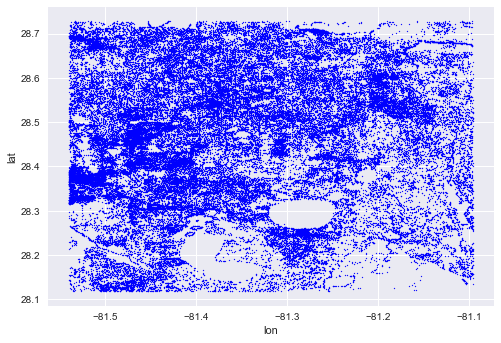

In [10]:
c.execute("SELECT lat, lon from nodes;")
big_list=c.fetchall()
lat=[]
lon=[]
for item in big_list:
    lat.append(item[0])
    lon.append(item[1])
    
plt.scatter(lon, lat, color="blue", s=1)
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

So all the latitude and longitude values seem to fall in the expected range, no wild outliers. Also, the units are consistent (in degrees), so these fields conform to the correct units __(uniform)__.

[The postcode in Orlando](http://united-states.postcode.info/florida/orlando) ("gold standard"):

In [11]:
orlando_postcodes=[32801, 32802, 32803, 32804, 32805, 32806, 32807, 32808, 32809, 
                   32810, 32811, 32812, 32813, 32814, 32815, 32816, 32817, 32818, 
                   32819, 32820, 32821, 32822, 32824, 32825, 32826, 32827, 32828, 
                   32829, 32830, 32831, 32832, 32833, 32834, 32835, 32836, 32837, 
                   32839, 32853, 32854, 32855, 32856, 32857, 32858, 32859, 32860, 
                   32861, 32862, 32867, 32868, 32869, 32872, 32877, 32878, 32885, 
                   32886, 32887, 32889, 32890, 32891, 32893, 32896, 32897, 32898, 32899]
#let's make a table of all the postcodes
conn = sqlite3.connect('open_street_map/csv_files/orlando.db')
c = conn.cursor()
QUERY="SELECT value, count(*) as num from nodes_tags where ltrim(key) like '%code' "\
"group by nodes_tags.value order by num desc"
c.execute(QUERY)
node_codes=c.fetchall()
for item in node_codes:
    print(item[0]+" | "+str(item[1]))

32708 | 5
32789 | 4
32803 | 4
32819 | 4
32837 | 4
34746 | 4
32792 | 2
32801 | 2
32809 | 2
32821 | 2
32827 | 2
32836 | 2
34741 | 2
32701 | 1
32703 | 1
32750 | 1
32804 | 1
32805 | 1
32806 | 1
32807 | 1
32808 | 1
32822 | 1
32835 | 1
34761 | 1
34769 | 1
34771 | 1


I think these postcodes are okay - they are surrounding areas like Osceola County. Not really inaccurate values. So far, we have done two checks of accuracies, and it seems that for the subsample, __the data is accurate__. Although there maybe issues we will encounter when we really start thinking about the subtags.

We can also check for consistency that two different postcodes weren't entered for the same node. This can be done by looking into the nodes tags table, ordering objects by node ids, where keys="postcode" and seeing if we find any inconsistency.

We are going to do that using a subquery - first we find all nodes with a postcode, and then check if a node has a postcode entry more than once. If it does, than we can check to see if they are the same. If they are different, then there is an inconsistency.

(__Note:__ The second line of code in the next cell (commented out) gives the list of postcodes. It is a long list, so I am using the subquery to just show there is no instance of repetition of postcodes).

In [13]:
#conn = sqlite3.connect('open_street_map/csv_files/orlando.db')
c = conn.cursor()
#this query creates a subquery table with a column repeatedpostcodes,
#which is just the count of how many tags of postcode appear
#connected to the same node id. If multiple tags of postcode
#are connected to the same node id, we can check for inconsistency
QUERY="SELECT repeatedpostcodes from (SELECT id, key, value, count(id) "\
"as repeatedpostcodes from nodes_tags where key='postcode' group by id order "\
"by id) where repeatedpostcodes>1"
c.execute(QUERY)
#c.execute("SELECT id, key, value, count(id) from nodes_tags where key='postcode' group by id order by id")
c.fetchall()

[]

There is no instance of repetition for a postcode for a particular node. So, at least in terms of postcode __the data is consistent__.

## Insights from data

Now that we have made sure that the data is valid, accurate, consistent, complete and uniform, we can move on to getting some real insights about the area. Such as,

* What are some of the biggest chain stores in Orlando?
* What restaurant chains does it have?
* How many nodes are there referring to alligators?
* How many refers to Disney?
* How many to Universal?
* Top ten contributors and the number of entries they contributed to.

But first, we must parse the big osm file, convert it from xml to csv and then to sqlite. To convert to csv:

In [ ]:
#Convert everything to csv:
output_folder="open_street_map/csv_files/"
suffix="_whole.csv"
if __name__ == '__main__':
    audit.process_map(OSM_FILE, output_folder, suffix, validate=True)

I cleared the long output from the previous cell, but looking through all the outputs was useful to catch street names ending with "Plaza", "Stars" (Avenue of the Stars) and "Pkwy". I edited the code to take care of that.

Here's a peculiar error I found, one person entered this street address:
"N John Young Pkwy, Kissimmee, FL, United States". Which is an entry error - State and country information should not be filed with the subtag key "addr:street". This kind of issue can be detected programatically (by looking for commas inside attrib['v'] subtags, and checking to see if it also includes city, country, state names). I don't attempt to do it here, but this can be part of additional cleaning - to break down subtags with too much information into seperate subtags.

In [4]:
#csv to sqlite - same way we did for the sample file
#conn.close()
conn = sqlite3.connect('open_street_map/csv_files/orlando_whole.db')
c = conn.cursor()
# Create table
c.execute("CREATE TABLE nodes(id NUMERIC,version INTEGER,lat FLOAT,lon FLOAT,changeset NUMERIC,uid INTEGER,timestamp DATETIME,user TEXT,primary key(id))")

with open('open_street_map/csv_files/nodes_whole.csv','rt', encoding= "utf8") as fin: 
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['version'], i['changeset'], i['lon'], i['lat'], i['uid'], i['timestamp'], i['user']) for i in dr]

c.executemany("INSERT INTO nodes(id, version, changeset, lon, lat, uid, timestamp, user) VALUES (?, ?, ?, ?, ?, ?, ?, ?);", to_db)
conn.commit()

#node tags table:
c.execute("CREATE TABLE nodes_tags(id NUMERIC references nodes(id), key TEXT, value TEXT, type TEXT)")

with open('open_street_map/csv_files/nodes_tags_whole.csv','rt', encoding= "utf8") as fin: 
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]

c.executemany("INSERT INTO nodes_tags(id, key, value, type) VALUES (?, ?, ?, ?);", to_db)
conn.commit()

#ways table
c.execute("CREATE TABLE ways(id NUMERIC,version INTEGER,changeset NUMERIC,uid INTEGER,timestamp DATETIME,user TEXT,primary key(id))")

with open('open_street_map/csv_files/ways_whole.csv','rt', encoding= "utf8") as fin: 
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['version'], i['changeset'], i['uid'], i['timestamp'], i['user']) for i in dr]

c.executemany("INSERT INTO ways(id, version, changeset, uid, timestamp, user) VALUES (?, ?, ?, ?, ?, ?);", to_db)
conn.commit()

#ways tags table:
c.execute("CREATE TABLE ways_tags(id NUMERIC references ways(id), key TEXT, value TEXT, type TEXT)")

with open('open_street_map/csv_files/ways_tags_whole.csv','rt', encoding= "utf8") as fin:
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]

c.executemany("INSERT INTO ways_tags(id, key, value, type) VALUES (?, ?, ?, ?);", to_db)
conn.commit()

#ways nodes table:
c.execute("CREATE TABLE ways_nodes(id NUMERIC references ways(id), node_id NUMERIC references nodes(id), position INTEGER)")

with open('open_street_map/csv_files/ways_nodes_whole.csv','rt', encoding= "utf8") as fin: # `with` statement available in 2.5+
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['node_id'], i['position']) for i in dr]

c.executemany("INSERT INTO ways_nodes(id, node_id, position) VALUES (?, ?, ?);", to_db)
conn.commit()

#relations table
c.execute("CREATE TABLE relations(id NUMERIC,version INTEGER,changeset NUMERIC,uid INTEGER,timestamp DATETIME,user TEXT,primary key(id))")

with open('open_street_map/csv_files/relations_whole.csv','rt', encoding= "utf8") as fin: 
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['version'], i['changeset'], i['uid'], i['timestamp'], i['user']) for i in dr]

c.executemany("INSERT INTO relations(id, version, changeset, uid, timestamp, user) VALUES (?, ?, ?, ?, ?, ?);", to_db)
conn.commit()

#ways tags table:
c.execute("CREATE TABLE relations_tags(id NUMERIC references relations(id), key TEXT, value TEXT, type TEXT)")

with open('open_street_map/csv_files/relations_tags_whole.csv','rt', encoding= "utf8") as fin:
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]

c.executemany("INSERT INTO relations_tags(id, key, value, type) VALUES (?, ?, ?, ?);", to_db)
conn.commit()

#relations members
c.execute("CREATE TABLE relations_members(id NUMERIC references relations(id), node_id NUMERIC references nodes(id), way_id NUMERIC references ways(id), relation_id NUMERIC references relations(id), role TEXT)")

with open('open_street_map/csv_files/relations_members_whole.csv','rt', encoding= "utf8") as fin:
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    #print(str(dr.fieldnames))
    to_db=[]
    for item in dr:
        if "node" in item["ref_to"]:
            one_tuple=(item["id"],item["ref_id"],None,None,item["role"])
            to_db.append(one_tuple)
        elif "way" in item["ref_to"]:
            one_tuple=(item["id"],None,item["ref_id"],None,item["role"])
            to_db.append(one_tuple)
        elif "relation" in item["ref_to"]:
            one_tuple=(item["id"],None,None,item["ref_id"],item["role"])
            to_db.append(one_tuple)
        else:
            print(item)
    #to_db = [(i['id'], i['ref_id'], i['ref_to'], i['role']) for i in dr]

c.executemany("INSERT INTO relations_members(id, node_id, way_id, relation_id, role) VALUES (?, ?, ?, ?, ?);", to_db)
conn.commit()
conn.close()

 File sizes of the .osm file and the csv files:
 
* orlando.osm | 216.3MB
* remake_sample.osm | 21.8MB
* orlando_whole.db | 147.2MB
* nodes_tags_whole.csv | 2.9MB
* nodes_whole.csv | 73MB
* relations_members_whole.csv | 11.6MB 
* relations_tags_whole.csv | 1.1MB
* relations_whole.csv | 344KB
* ways_nodes_whole.csv | 27.1MB
* ways_tags_whole.csv | 19MB
* ways_whole.csv | 7MB

Let us start with finding out different type of entries we have (nodes/ways/relations).

In [5]:
conn = sqlite3.connect('open_street_map/csv_files/orlando_whole.db')
c = conn.cursor()
#Number of nodes:
QUERY="SELECT count(*) from nodes"
c.execute(QUERY)
print("Number of nodes: ", c.fetchall()[0][0])
#Nmber of ways:
QUERY="SELECT count(*) from ways"
c.execute(QUERY)
print("Number of ways: ", c.fetchall()[0][0])
#Number of relations:
QUERY="SELECT count(*) from relations"
c.execute(QUERY)
print("Number of relations: ", c.fetchall()[0][0])

Number of nodes:  958446
Number of ways:  122905
Number of relations:  6446


Let us explore the questions we posed earlier about the area, starting with the types of chain stores that show up frequently in Orlando:

In [6]:
#Stores
#I use a subquery to make a list of nodes ids that
#belong to stores/markets/shops
#then look for other tags that refer to the same node id
#but give us the name of the store instead of some other key
#then I group these names together and count how many chain stores there are
#in the area, and print out top 10 most ubiquitous stores
QUERY="SELECT nodes_tags.value, count(upper(nodes_tags.value)) as total from nodes_tags "\
"where (nodes_tags.id in (SELECT nodes_tags.id as id"\
" from nodes_tags where "\
"(nodes_tags.key like '%store' "\
"or nodes_tags.key like '%market' or nodes_tags.key like '%shop%')) and "\
"ltrim(nodes_tags.key) like '%name%') group by upper(nodes_tags.value) order by total desc limit 10"

c.execute(QUERY)
output=c.fetchall()

print("Most common type of chain stores:")
print("-----------------------------------")
for item in output:
    print(item[0], str(item[1]))

Most common type of chain stores:
-----------------------------------
Publix 40
ALDI 16
Home Depot 7
Walmart Supercenter 7
Dollar Tree 6
Lowe's 6
Walmart Neighborhood Market 6
AT&T 5
Gift Shop 5
Ross 5


This returns all kinds of stores as I expected. But I just want to know about supermarket or grocery stores.

In [7]:
#Stores
QUERY="SELECT nodes_tags.value, count(upper(nodes_tags.value)) as total from nodes_tags "\
"where (nodes_tags.id in (SELECT nodes_tags.id as id"\
" from nodes_tags where "\
"(nodes_tags.value like '%supermarket%')) and "\
"ltrim(nodes_tags.key) like '%name%') group by upper(nodes_tags.value) order by total desc limit 10"

c.execute(QUERY)
output=c.fetchall()

print("Most common type of grocery stores:")
print("-----------------------------------")
for item in output:
    print(item[0], str(item[1]))

Most common type of grocery stores:
-----------------------------------
Publix 40
ALDI 16
Walmart Neighborhood Market 6
Winn Dixie 5
Save-a-Lot 3
Winn-Dixie 3
Pet Supermarket 2
Sedano's 2
Super Market 2
Trader Joe's 2


In [8]:
#types of cuisine that are popular
QUERY="SELECT nodes_tags.value, count(upper(nodes_tags.value)) as total from nodes_tags where"\
" nodes_tags.key='cuisine' group by upper(nodes_tags.value) order by total desc limit 10"
c.execute(QUERY)
output=c.fetchall()

print("Most common types of cuisine:")
print("-----------------------------")
for item in output:
    print(item[0], str(item[1]))

Most common types of cuisine:
-----------------------------
burger 106
american 31
pizza 28
mexican 23
chinese 20
sandwich 19
coffee_shop 14
italian 9
chicken 8
donut 7


I guess this is predictable, lots of Burger King/McDonalds everywhere in US. Mexican and chinese food also seem very popular. What are the different types of burger places they have in Orlando?

In [9]:
#types of cuisine that are popular
QUERY="SELECT nodes_tags.value, count(upper(nodes_tags.value)) as total from nodes_tags where"\
" (nodes_tags.id in (SELECT nodes_tags.id from nodes_tags where (nodes_tags.key='cuisine' and nodes_tags.value='burger'))"\
" and nodes_tags.key='name') group by upper(nodes_tags.value) order by total desc limit 5"
c.execute(QUERY)
output=c.fetchall()

print("Most common burger places:")
print("--------------------------")
for item in output:
    print(item[0], str(item[1]))

Most common burger places:
--------------------------
McDonald's 53
Burger King 25
Wendy's 22
Burger King Whopper Bar 1
Cheeburger Cheeburger 1


So they have no famous local burger chains like In n' out in California. 

I would also like to find out the different types of amenities in the region, I predict that there would be lots of places of worship, which is clear from glancing at the csv file.

In [10]:
#types of cuisine that are popular
QUERY="SELECT nodes_tags.value, count(upper(nodes_tags.value)) as total from nodes_tags where"\
" nodes_tags.key='amenity' group by upper(nodes_tags.value) order by total desc limit 10"
c.execute(QUERY)
output=c.fetchall()

print("Amenities:")
print("---------")
for item in output:
    print(item[0], str(item[1]))

Amenities:
---------
place_of_worship 579
restaurant 310
fast_food 293
school 186
fountain 136
fuel 115
bicycle_parking 88
fire_station 77
bank 72
parking 60


Okay now let us find out about which users contribute the most to this dataset.

In [11]:
QUERY="SELECT uid, user, count(uid) as num from relations"\
" group by uid order by num desc limit 10"
c.execute(QUERY)
relations_user=c.fetchall()

QUERY="SELECT uid, user, count(uid) as num from ways"\
" group by uid order by num desc limit 10"
c.execute(QUERY)
ways_user=c.fetchall()

QUERY="SELECT uid, user, count(uid) as num from nodes"\
" group by uid order by num desc limit 10"
c.execute(QUERY)
nodes_user=c.fetchall()

#print out nicely:
print("Relations contributors:")
print("-----------------------")
for item in relations_user:
    print(item[1], str(item[2]))

Relations contributors:
-----------------------
NE2 5110
epcotfan 228
maxerickson 122
valerietheblonde 87
sayno2quat 86
3yoda 62
GoWestTravel 60
Brian@Brea 48
Perfal 41
nyuriks 40


In [12]:
#print out nicely:
print("Ways contributors:")
print("------------------")
for item in ways_user:
    print(item[1], str(item[2]))

Ways contributors:
------------------
NE2 65426
valerietheblonde 5531
3yoda 3535
epcotfan 2960
Brian@Brea 2414
thetornado76 2344
Cdale1986 2240
bot-mode 2046
grouper 1871
Adam Martin 1511


In [13]:
#print out nicely:
print("Nodes contributors:")
print("-------------------")
for item in nodes_user:
    print(item[1], str(item[2]))

Nodes contributors:
-------------------
NE2 422761
valerietheblonde 42608
crystalwalrein 36513
3yoda 35341
grouper 31522
dale_p 23112
epcotfan 21453
Adam Martin 19158
Brian@Brea 18166
KindredCoda 17066


Overall:

In [14]:
#this query takes in all user ids from all three types of
#top level events, and finds the top 10 most prolific contributors
QUERY="SELECT  uid, user, count(uid) as num FROM "\
"(SELECT uid, user FROM nodes UNION ALL SELECT uid, user FROM ways UNION ALL SELECT uid, "\
"user FROM relations) group by uid order by num desc limit 10"

c.execute(QUERY)
all_user=c.fetchall()

#print out nicely:
print("Highest contributors:")
print("----------------------")
for item in all_user:
    print(item[1], str(item[2]))

Highest contributors:
----------------------
NE2 493297
valerietheblonde 48226
3yoda 38938
crystalwalrein 36699
grouper 33404
epcotfan 24641
dale_p 24326
Adam Martin 20673
Brian@Brea 20628
RobChafer 18449


Total number of unique users:

In [15]:
QUERY="SELECT count(DISTINCT(uid)) as num from relations"
c.execute(QUERY)
relations_user=c.fetchall()

#Another way to do this:
QUERY="SELECT count(uid) from (SELECT uid from relations group by uid)"
c.execute(QUERY)
relations_user_2=c.fetchall()

QUERY="SELECT count(DISTINCT(uid)) as num from ways"
c.execute(QUERY)
ways_user=c.fetchall()

QUERY="SELECT count(DISTINCT(uid)) as num from nodes"
c.execute(QUERY)
nodes_user=c.fetchall()

QUERY="SELECT count(DISTINCT(uid)) as num from (SELECT uid from nodes"\
" UNION ALL SELECT uid from ways UNION ALL SELECT uid from relations)"
c.execute(QUERY)
all_user=c.fetchall()

print("Number of unique users for relations: ", relations_user[0][0])
print("Alternate method: ", relations_user_2[0][0])
print("Number of unique users for ways: ", ways_user[0][0])
print("Number of unique users for nodes: ", nodes_user[0][0])
print("Total number of unique users in that area: ", all_user[0][0])

Number of unique users for relations:  147
Alternate method:  147
Number of unique users for ways:  557
Number of unique users for nodes:  715
Total number of unique users in that area:  826


So around 826 people contributed to recording information about Orlando and surrounding area.

It looks like most of the things I did also show up in the sample project, but I didn't look at the specifics of that file before doing my project :S

Anyway, let us find out something very specific to Florida: Alligator related nodes.

In [16]:
QUERY="SELECT id, key, value "\
"from nodes_tags where (key like '%alligator%' COLLATE NOCASE or "\
"value like '%alligator%' COLLATE NOCASE)"
c.execute(QUERY)
c.fetchall()

[]

That is disappointing. Maybe I can find some places from Universal Studios, like the Simpsons or something from Harry Potter World.

In [17]:
QUERY="SELECT id, key, value from nodes_tags where (value like '%Hogsmeade%' or "\
"value like '%King%s Cross%' or value like '%Simpsons%')"
c.execute(QUERY)
c.fetchall()

[(2409455843, 'name', 'Simpsons Fast Food Boulevard'),
 (2987354815, 'name', 'Hogsmeade Station'),
 (2987354815, 'alt_name', 'Hogsmeade'),
 (2987354819, 'name', "King's Cross station"),
 (3687251875, 'name', "King's Cross"),
 (3687251882, 'name', 'Hogsmeade')]

So this is something I did not think about before, there are several nodes referring to the same thing. This is possibly because there are slightly different latitude and longitude values as the place is not just a single point. This is why the system cannot recognize they are both referring to the same thing. A repetition cleaning can also be considered as further work.

## Further work and Conclusions

From previous section, we know that multiple nodes refer to the same location. This kind of repetition can be removed if the database checks nearby tags (nearby in location, i.e., using latitude and longitude), and checks the "name" of those fields as well. If the (regardless of case) names of two or more very nearby locations with different node ids are also very similar, the database can flag these nodes as items that need user review. Than users can review whether or not these are repetitions, or whether subtags need to be merged for these two fields.

Another issue is the issue of misspelling, or the issue of nonconforming data entry. We jsut cleaned street type, but other fields, such as names of chain stores might be mispelled too. This can possibly be checked using a more sophisticated shape element function, but that is beyond what I can do for this project.

I tried a little bit to explore an area I know quite well by using latitude, longitude:

In [ ]:
#find out all nodes that refer to Universal. This can be done in two ways
#first check tags that have the value "Universal" in it.
#But this could be referring to Universal Boulevard, which is a street and therefore
#not really part of universal studios
#so a better way is to select by latitude and longitude and then check node number/usernames.
#location: lat,lon: 28.474321°,-81.467819°, 
#LATITUDE RANGE: 28.468484, 28.482434
#LONGITUDE RANGE: -81.474761,-81.4599335
#QUERY="SELECT nodes.id, nodes.uid, nodes.user, nodes.lon, nodes.lat, nodes_tags.key, nodes_tags.value from nodes, nodes_tags where (nodes.lon>-81.474761 and nodes.lon<-81.4599335 and nodes.lat>28.468484 and nodes.lat<28.482434 and nodes_tags.value like '%Universal%')"
QUERY="SELECT nodes.id, nodes.uid, nodes.user, nodes.lon, nodes.lat, nodes_tags.key, nodes_tags.value from nodes, nodes_tags where (nodes.lon>(-81.467819-0.008) and nodes.lon<(-81.467819+0.008) and nodes.lat>(28.474321-0.008) and nodes.lat<(28.474321+0.008))"
c.execute(QUERY)
mtable=c.fetchall()
'''
with open('open_street_map/csv_files/universal_nodes.csv', 'w', newline='') as f:
    a = csv.writer(f, delimiter=',')
    for line in mtable:
        a.writerow(line)
'''
        
#just to be sure that the sql is working with the latitude and longitude constraints:
lat=[]
lon=[]
for item in mtable:
    lat.append(item[4])
    lon.append(item[3])
    
plt.scatter(lon, lat, color="blue", s=1)
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

This dataset (universal_nodes.csv) is more than 1 GB, and just by looking into the file, I see that it includes everything including highway, exit to and a lot of information about objects not really related to Universal Studios. To find "nearby" locations to a node, the system should use a smaller radius than I did, although I was trying to find everything within Universal Studios.

### To summarize the issues I found and sugestions for further work:

* It obviously is not complete as I cannot find some of the restaurants I remember from Universal. Users should be able to flag areas that are missing description, so that the community is encouraged (via email notifications) to contribute adding more entries about that area.
* There will be mispelled names. We can fix names of chain stores programatically. But it is trickier to find "gold standard data" for local establishments (unless maybe we can compare with some other source, such as google maps). Some user input and checks would be required for it. One way to minimize user input is to have a "autocomplete" feature during data entry. If someone is entering "mcd...", and the system knows that this information is about a burger place, it can suggest "McDonald's"
* There is repetition in nodes. Several nodes refer to Hogsmeade Station. An autocomplete feature could also check for nearby (locationally) tags that have similar "names", and ask the user if they are referring to the same place or not. If a node referring to take place already exists, then the new entry is not added, or only new subtags containing information that the place did not have before is added.
* Sometimes users tend to input too much information in subtags, I found a subtag with the key "addr:street" that also included state and country information. Entries like these need to be broken up into several subtags.  It can at least partly be done programatically, by looking at attrib['v'] with commas and searching to see if a street addres also contains name of the city etc.
* Maybe the data entry interface can be changed. If someone is adding a usual subtag, such as phone number, they can choose that from a dropdown menu of usual "keys", and the "value" field can then also have the appropriate formatting. This might be able to take care most of the formatting issues. To prevent people from entering excess informaton (such as State and country information along with street address), there can be an upper limit on how much data can be entered as "value". For unusual subtags, there can be an "other" field.
* Every year, top contributors in an area can be selected for a prize. This would encourage more people to participate.

The issue with data cleaning for such massive datasets is that it is time and memory consuming. Taking care of the repetition bit would be difficult because for each node, a codes needs to take into account all nodes within a certain latitude/longitude range. Doing a spatial search like this takes time, and even a small area may have a lot of nodes, which is what I found while trying to isolate all the nodes for Universal Studios. Then the names of those nodes (from subtags) can be matched to weed out repeated entries. It would be a little bit of code, but might take a lot of processing time.